# Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [3]:
logger.setLevel(logging.DEBUG)

In [4]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Options

In [5]:
analyze_crops = False

# Metadata/paths objects

## Model

In [6]:
model_paths = ModelPaths(model_name := "dryrun-03")
logger.info(f"{model_paths=}")

[2020-11-05::22:05:54.843] tomo2seg :: INFO :: {<ipython-input-6-7890bf79ae61>:<module>:002}
model_paths=ModelPaths(name='dryrun-03', version=None)



## Volume

In [7]:
volume = Volume.with_check(
    volume_name := tomo2seg_data.VOLUME_PRECIPITATES_DRYRUN, 
    volume_version := "val"  # this is not supposed to be used like this...
)
logger.info(f"{volume=}")

[2020-11-05::22:05:55.248] tomo2seg :: DEBUG :: {data.py:with_check:169}
vol=Volume(name='PA66GF30_trans3_x__0_pag', version='val', _metadata=None)

[2020-11-05::22:05:55.252] tomo2seg :: WARNING :: {data.py:with_check:191}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.weights.raw

[2020-11-05::22:05:55.253] tomo2seg :: DEBUG :: {data.py:metadata:132}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.metadata.yml`.

[2020-11-05::22:05:55.259] tomo2seg :: INFO :: {<ipython-input-7-114fba72e626>:<module>:005}
volume=Volume(name='PA66GF30_trans3_x__0_pag', version='val', _metadata=Volume.Metadata(dimensions=[500, 500, 500], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions=None))



In [8]:
hst_read = lambda x: functools.partial(
    # from pymicro
    file_utils.HST_read,
    
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x))  # it doesn't accept paths...

## Estimation volume

In [9]:
estimation_volume = EstimationVolume.from_objects(volume=volume, model=model_paths)
logger.info(f"{estimation_volume=}")

[2020-11-05::22:05:56.929] tomo2seg :: INFO :: {<ipython-input-9-6a0502a4bb51>:<module>:002}
estimation_volume=EstimationVolume(volume_name='PA66GF30_trans3_x__0_pag', volume_version='val', model_name='dryrun-03', model_version=None, partition=None, _metadata=None)



In [10]:
logger.info(f"{estimation_volume.dir=}")  # this makes sure that the folder exists

[2020-11-05::22:05:57.742] tomo2seg :: INFO :: {<ipython-input-10-f8d61e030c3b>:<module>:001}
estimation_volume.dir=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03')



# Load from the disk

In [11]:
logger.debug("Loading data from disk.")

[2020-11-05::20:54:04.067] tomo2seg :: DEBUG :: {<ipython-input-11-ded26959866d>:<module>:001}
Loading data from disk.



## Data

In [12]:
data_volume = hst_read(volume.data_path)
logger.debug(f"{data_volume.shape=}")

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
[2020-11-05::22:06:08.074] tomo2seg :: DEBUG :: {<ipython-input-12-b7176a818869>:<module>:002}
data_volume.shape=(500, 500, 500)



## Labels

In [13]:
labels_volume = hst_read(volume.labels_path)
logger.debug(f"{labels_volume.shape=}")

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
[2020-11-05::22:06:09.886] tomo2seg :: DEBUG :: {<ipython-input-13-cbfd739cafb5>:<module>:002}
labels_volume.shape=(500, 500, 500)



## Probabilities

In [52]:
probabilities_are_available = False

if estimation_volume.probabilities_path.exists():
    probas_volume = np.load(estimation_volume.probabilities_path).astype(np.float16)  # float16 instead of 64 to save memory
    probabilities_are_available = True
    logger.debug(f"{probas_volume.shape=}")
else:
    logger.warning("Probabilities are not available.")

[2020-11-05::22:48:24.811] tomo2seg :: DEBUG :: {<ipython-input-52-1bfdaf7903cf>:<module>:006}
probas_volume.shape=(500, 500, 500, 3)



## Predictions

In [15]:
predictions_volume = hst_read(estimation_volume.predictions_path)
logger.debug(f"{predictions_volume.shape=}")

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
[2020-11-05::20:54:08.181] tomo2seg :: DEBUG :: {<ipython-input-15-b50f2fef3a1b>:<module>:002}
predictions_volume.shape=(500, 500, 500)



# Class imbalance

In [14]:
logger.debug(f"{(labels_idx := volume.metadata.labels)=}")
logger.debug(f"{(labels_names := [volume.metadata.labels_names[idx] for idx in labels_idx])=}")
logger.debug(f"{(n_classes := len(labels_idx))=}")
logger.debug(f"{(n_voxels := functools.reduce(np.multiply, volume.metadata.dimensions))}")

figs_common_metadata = dict(Author="joaopcbertoldo", CreationTime=str(int(time.time())), Software="tomo2seg")
figs_common_kwargs = dict(bbox_inches="tight", format="png")

[2020-11-05::22:06:13.332] tomo2seg :: DEBUG :: {<ipython-input-14-d1a97d62a379>:<module>:001}
(labels_idx := volume.metadata.labels)=[0, 1, 2]

[2020-11-05::22:06:13.333] tomo2seg :: DEBUG :: {<ipython-input-14-d1a97d62a379>:<module>:002}
(labels_names := [volume.metadata.labels_names[idx] for idx in labels_idx])=['matrix', 'fiber', 'porosity']

[2020-11-05::22:06:13.334] tomo2seg :: DEBUG :: {<ipython-input-14-d1a97d62a379>:<module>:003}
(n_classes := len(labels_idx))=3

[2020-11-05::22:06:13.338] tomo2seg :: DEBUG :: {<ipython-input-14-d1a97d62a379>:<module>:004}
125000000



In [15]:
logger.info("Computing label class imbalance.")
_, labels_counts = np.unique(labels_volume, return_counts=True)

[2020-11-05::22:06:13.521] tomo2seg :: INFO :: {<ipython-input-15-7e3186c17741>:<module>:001}
Computing label class imbalance.



[2020-11-05::22:06:17.150] tomo2seg :: INFO :: {<ipython-input-16-b1c5682667d4>:<module>:001}
Saving figure (fig_name := 'class-imbalance.png')='class-imbalance.png'



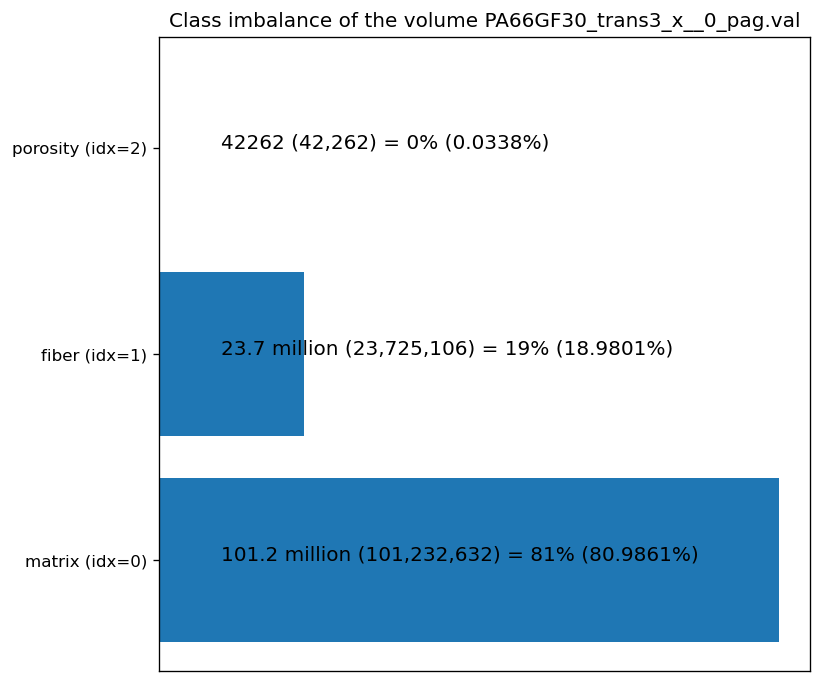

In [16]:
logger.info(f"Saving figure {(fig_name := 'class-imbalance.png')=}")
fig, ax = plt.subplots(1, 1, figsize=(sz := 7, sz), dpi=(dpi := 120))

ax.barh(labels_idx, labels_counts)
ax.set_yticks(labels_idx)
ax.set_yticklabels([f"{labels_names[idx]} ({idx=})" for idx in labels_idx])
ax.set_xticks([])
for idx, count in zip(labels_idx, labels_counts.tolist()):
    ax.text(
        max(labels_counts) // 10, idx, 
        f"{humanize.intword(count)} ({humanize.intcomma(count)}) = {(perc := count / n_voxels):.0%} ({perc:.4%})",
        fontsize="large"
    )
    
ax.set_title(f"Class imbalance of the volume {volume.fullname}")

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

In [17]:
logger.info(f"The minimum accuracy is: {(random_model_accu := max(labels_counts) / n_voxels)=:.2%}")

[2020-11-05::22:06:17.540] tomo2seg :: INFO :: {<ipython-input-17-5a48a06677ee>:<module>:001}
The minimum accuracy is: (random_model_accu := max(labels_counts) / n_voxels)=80.99%



# Value histograms

In [18]:
data_volume_raveled_t = tf.convert_to_tensor(
    value=data_volume.ravel(),
    dtype=tf.int32,
    name=f"{volume.fullname}-data-raveled"
)

## All data

In [19]:
data_hist_t = tf.histogram_fixed_width(
    values=data_volume_raveled_t,
    value_range=tf.constant((hist_range := [0, 255]), dtype=data_volume_raveled_t.dtype),
    nbins=(n_bins := 256),
    dtype=data_volume_raveled_t.dtype,
    name=f"{volume.fullname}.data-histogram"
)
data_hist_t = data_hist_t / tf.math.reduce_sum(data_hist_t)
# todo save these values# 

[2020-11-05::22:06:19.813] tomo2seg :: INFO :: {<ipython-input-20-1442f24707fe>:<module>:001}
Saving figure (fig_name := 'data-histogram.png')='data-histogram.png'



<ipython-input-20-1442f24707fe>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axlog.set_yticklabels(


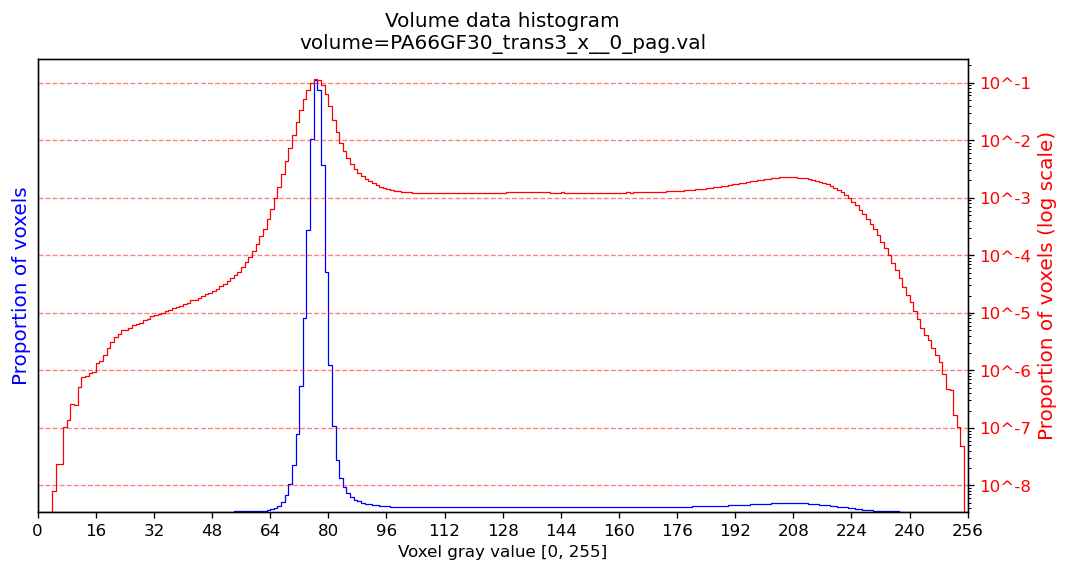

In [20]:
logger.info(f"Saving figure {(fig_name := 'data-histogram.png')=}")
fig, ax = plt.subplots(1, 1, figsize=(2 * (sz := 5), sz), dpi=(dpi := 120))

# i want to get the vertical borders to show up
bins = np.linspace(*hist_range, n_bins).astype(int).tolist() + [256, 257]  

ax.step(
    bins, 
    steps_values := [0] + data_hist_t.numpy().tolist() + [0], 
    linewidth=.75, c='blue',
    label='linear',
)
ax.set_xlim(0, 256)
ax.set_xticks(np.linspace(0, 256, 256//16 + 1))
ax.set_xlabel("Voxel gray value [0, 255]")

ax.set_ylim((0, 1.05 * max(steps_values)))
ax.set_ylabel("Proportion of voxels", c='blue', fontsize='large')
ax.set_yticks([])

axlog = ax.twinx()
axlog.step(
    bins, steps_values, 
    linewidth=.75, c='red',
    label='log'
)
axlog.set_yscale("log")
# axlog.set_ylim((1e-6, 1.5e0))
axlog.grid(axis='y', which='major', ls='--', c='red', alpha=.5)
axlog.set_yticklabels(
    [f"10^{int(np.log10(t)):d}" for t in axlog.get_yticks()], 
    c='red'
)
axlog.set_ylabel("Proportion of voxels (log scale)", c='red', fontsize='large')

ax.set_title(f"Volume data histogram\nvolume={volume.fullname}")

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

## Per label

In [21]:
labels_volume_raveled_t = tf.convert_to_tensor(
    labels_volume.ravel(), dtype=tf.int8
)

In [35]:
data_hists_per_label = []
data_hists_per_label_global_prop = []

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    label_data_hist_t = tf.histogram_fixed_width(
        values=data_volume_raveled_t[labels_volume_raveled_t == label_idx],
        value_range=tf.constant(hist_range, dtype=data_volume_raveled_t.dtype),
        nbins=n_bins,
        dtype=data_volume_raveled_t.dtype,
        name=f"{volume.fullname}.data-histogram"
    )
    data_hists_per_label.append(
        (label_data_hist_t / tf.math.reduce_sum(label_data_hist_t)).numpy()
    )
    data_hists_per_label_global_prop.append(

        label_data_hist_t.numpy() / 500**3
    )

# todo save these values# 

[2020-11-05::22:18:57.280] tomo2seg :: DEBUG :: {<ipython-input-35-fc1b334c646c>:<module>:005}
Computing histogram for label_idx=0

[2020-11-05::22:18:58.868] tomo2seg :: DEBUG :: {<ipython-input-35-fc1b334c646c>:<module>:005}
Computing histogram for label_idx=1

[2020-11-05::22:18:59.404] tomo2seg :: DEBUG :: {<ipython-input-35-fc1b334c646c>:<module>:005}
Computing histogram for label_idx=2



In [36]:
del label_data_hist_t

[2020-11-05::22:30:09.122] tomo2seg :: INFO :: {<ipython-input-43-6d924f053ac0>:<module>:001}
Saving figure (fig_name := 'data-histogram-per-label.png')='data-histogram-per-label.png'



<ipython-input-43-6d924f053ac0>:42: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axlog.set_ybound(lower=0)


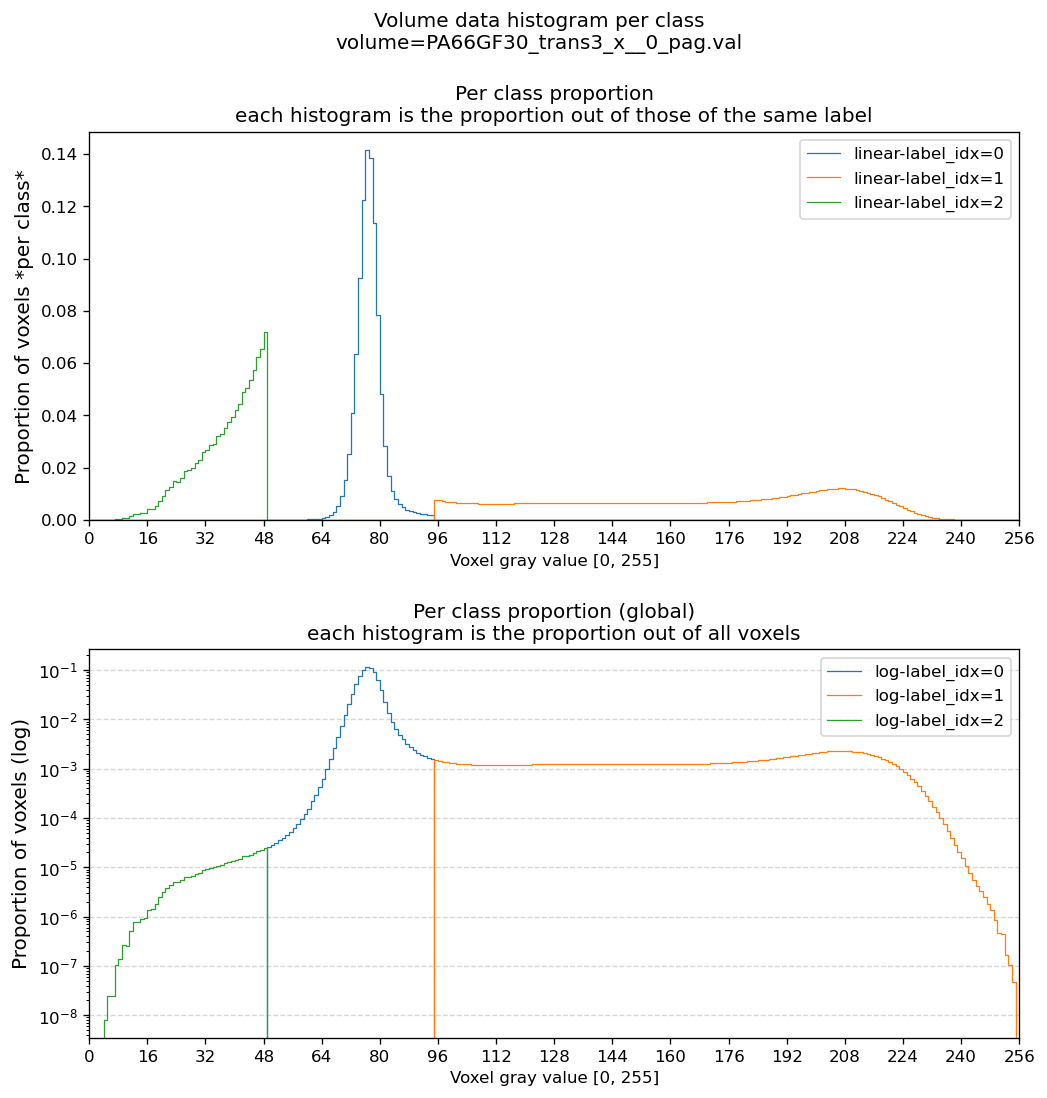

In [43]:
logger.info(f"Saving figure {(fig_name := 'data-histogram-per-label.png')=}")
fig, axs = plt.subplots(
    nrows := 2, ncols := 1, figsize=(ncols * 2 * (sz := 5), nrows * sz), dpi=(dpi := 120),
    gridspec_kw=dict(hspace=sz/15)
)

# i want to get the vertical borders to show up
bins = np.linspace(*hist_range, n_bins).astype(int).tolist() + [256, 257]  

axlin, axlog = axs

for label_idx, label_hist, label_hist_global in zip(
    labels_idx, data_hists_per_label, data_hists_per_label_global_prop
):

    axlin.step(
        bins, 
        steps_values := [0] + label_hist.tolist() + [0], 
        linewidth=.75,
        label=f"linear-{label_idx=}",
    )
    axlin.set_xlim(0, 256)
    axlin.set_xticks(np.linspace(0, 256, 256//16 + 1))
    axlin.set_xlabel("Voxel gray value [0, 255]")
    
    axlog.step(
        bins, 
        steps_values := [0] + label_hist_global.tolist() + [0], 
        linewidth=.75,
        label=f"log-{label_idx=}",
    )
    axlog.set_xlim(0, 256)
    axlog.set_xticks(np.linspace(0, 256, 256//16 + 1))
    axlog.set_xlabel("Voxel gray value [0, 255]")

axlin.set_ybound(lower=0)
axlin.set_ylabel("Proportion of voxels *per class*", fontsize='large')
axlin.legend()
axlin.set_title("Per class proportion\neach histogram is the proportion out of those of the same label")

axlog.set_yscale('log')
axlog.set_ybound(lower=0)
axlog.set_ylabel("Proportion of voxels (log)", fontsize='large')
axlog.legend()
axlog.set_title("Per class proportion (global)\neach histogram is the proportion out of all voxels")
axlog.grid(axis='y', which='major', ls='--', alpha=.5)

fig.suptitle(f"Volume data histogram per class\nvolume={volume.fullname}")

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

In [60]:
label_values_t.shape

TensorShape([42262])

In [85]:
logger.info("Computing grey values histogram of the enitre volume.")

histograms = []
bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume.ravel() == label_idx
    
    label_hists = []
    for class_proba_idx in labels_idx:
        values, _ = np.histogram(
            probas_volume_reshaped[selector, class_proba_idx], 
            bins=bins
        ) 
        label_hists.append(values / values.sum())
        
    histograms.append(label_hists)
    
histograms = np.array(histograms)

In [ ]:
estimation_volume.voxel_normalized_entropy_path

for label_idx in labels_idx:


# Per-class predicted probabilities histograms

In [53]:
logger.info("Computing probability histograms per label.")
probas_volume_reshaped = probas_volume.reshape(-1, n_classes)

[2020-11-05::22:48:33.563] tomo2seg :: INFO :: {<ipython-input-53-d04daec5ceae>:<module>:001}
Computing probability histograms per label.



In [85]:
histograms = []
bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume.ravel() == label_idx
    
    label_hists = []
    for class_proba_idx in labels_idx:
        values, _ = np.histogram(
            probas_volume_reshaped[selector, class_proba_idx], bins=bins
        ) 
        label_hists.append(values / values.sum())
        
    histograms.append(label_hists)
    
histograms = np.array(histograms)

In [85]:
logger.info(f"Saving probabilities histograms at `{estimation_volume.probabilities_histograms_path=}`")
np.save(
    estimation_volume.probabilities_histograms_path,
    histograms
)

[2020-11-03::16:46:23.661] tomo2seg :: DEBUG :: {<ipython-input-237-3898eef376ee>:<module>:001}
Saving figure (fig_name := 'class-probabilities-per-label.png')='class-probabilities-per-label.png'



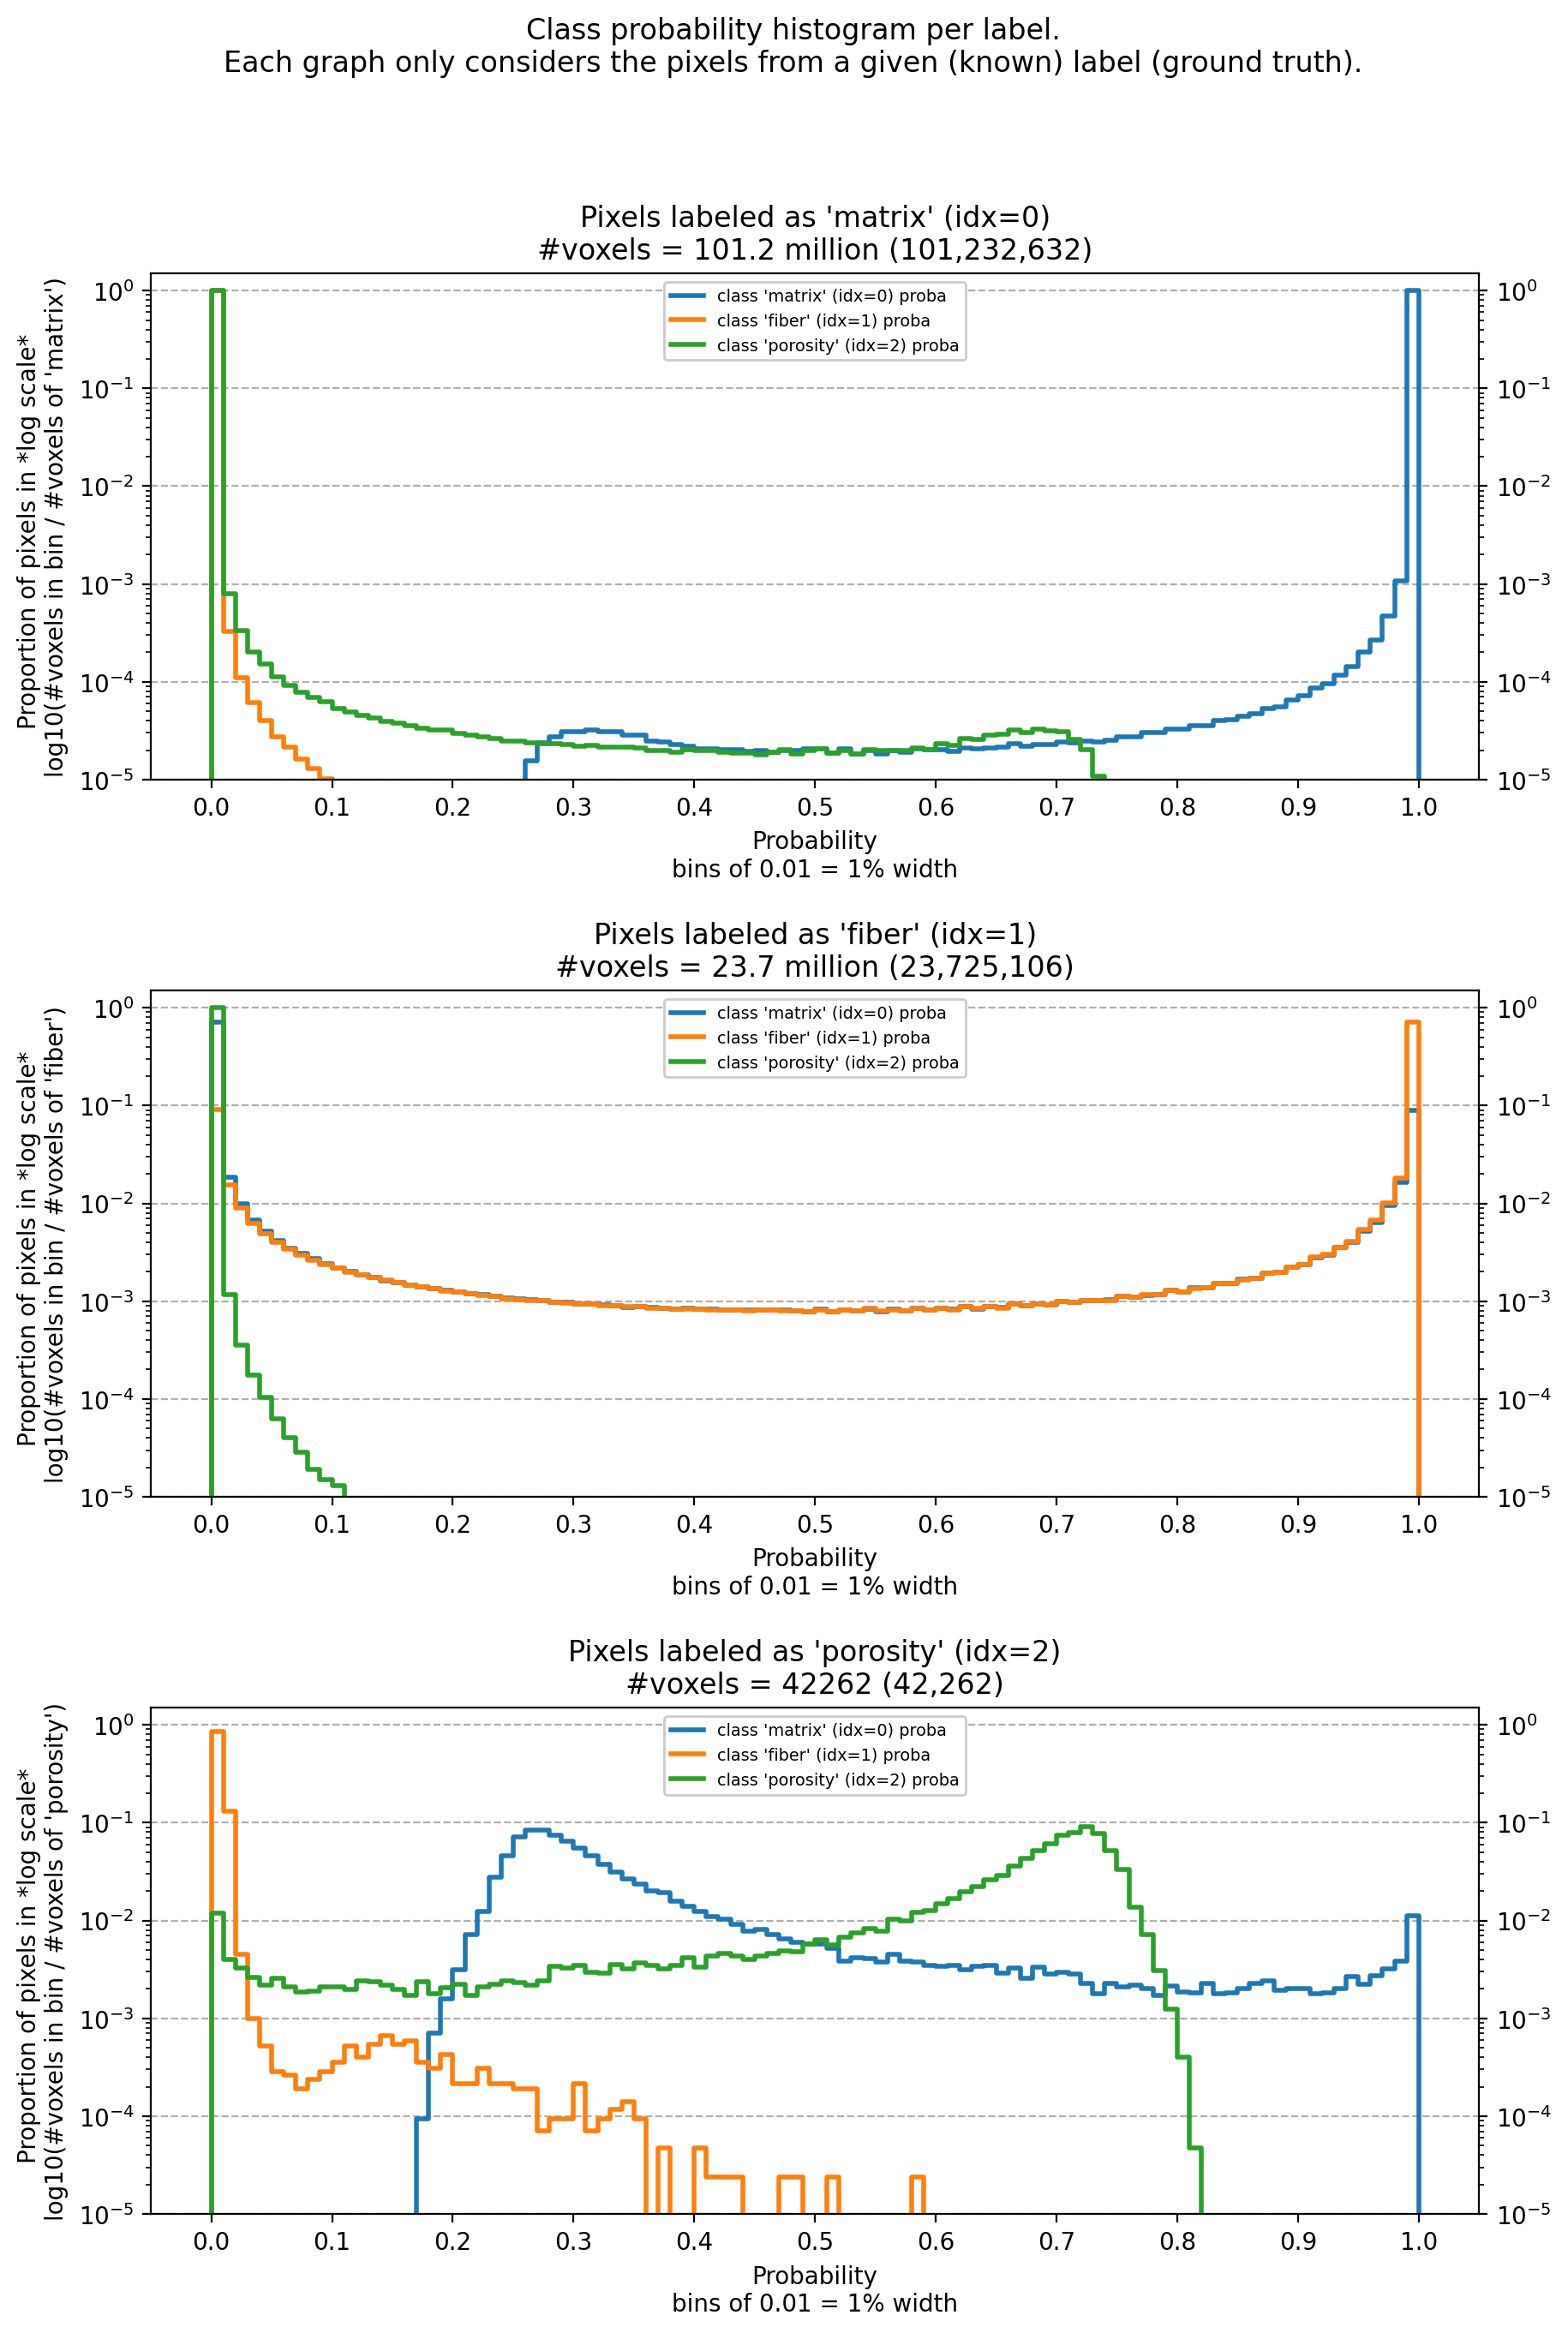

In [237]:
logger.info(f"Saving figure {(fig_name := 'class-probabilities-per-label.png')=}")

fig, axs = plt.subplots(
    3, 1, figsize=(2 * (sz := 5), 3 * sz), dpi=(dpi := 200),
    gridspec_kw=dict(wspace=0, hspace=sz/12)
)
xlims = (-.05, 1.05)
ylims_10pow = (-5, 0)
ylims = tuple(10 ** p for p in ylims_10pow)

for label_idx, ax in zip(labels_idx, axs.ravel()):
    logger.debug(f"Plotting histograms for {label_idx=}")
    
    for class_proba_idx in labels_idx:
        logger.debug(f"Drawing histogram for probability of {class_proba_idx=}")
        
        ax.step(
            np.concatenate([bins, [1.001]]),
            np.concatenate([[0], histograms[label_idx, class_proba_idx], [0]]),
            label=f"class '{labels_names[class_proba_idx]}' (idx={class_proba_idx}) proba",
            linewidth=2
        )
    
    ax.set_yscale('log')
    ax.set_ylim(ylims[0], 1.5 * ylims[1])
    ax.set_yticks(np.logspace(ylims_10pow[0], ylims_10pow[1], ylims_10pow[1] - ylims_10pow[0] + 1))
    ax.set_ylabel(
        f"Proportion of pixels in *log scale* \n"
        f"log10(#voxels in bin / #voxels of '{(label_name := labels_names[label_idx])}')"
    )
    
    ax.set_xlim(*xlims)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Probability\nbins of 0.01 = 1% width")

    ax.tick_params(axis='y', left=True, right=True, labelleft=True, labelright=True, which="both")    
    ax.grid(True, axis='y', which='major', ls='--')    
    
    ax.set_title(
        f"Pixels labeled as '{label_name}' (idx={label_idx})\n"
        f"#voxels = {humanize.intword(label_n_voxels := labels_counts[label_idx])} "
        f"({humanize.intcomma(label_n_voxels)})"
    )
    ax.legend(loc="upper center", fontsize="x-small", framealpha=1)

fig.suptitle(
    "Class probability histogram per label."
    "\nEach graph only considers the pixels from a given (known) label (ground truth)."
)
    
fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Prediction normalized entropy

In [29]:
eps = 1e-18
max_entropy = - np.log(1 / (n_classes + eps))

In [31]:
logger.info("Computing voxels' probability distribution normalized entropies.")
normalized_voxel_entropies = - (probas_volume * np.log(probas_volume + eps)).sum(axis=-1) / max_entropy

[2020-11-03::17:03:20.816] tomo2seg :: DEBUG :: {<ipython-input-31-6466c18d6187>:<module>:001}
Computing voxels' probability distribution normalized entropies.



<ipython-input-31-6466c18d6187>:2: RuntimeWarning: divide by zero encountered in log
  normalized_voxel_entropies = - (probas_volume * np.log(probas_volume + eps)).sum(axis=-1) / max_entropy
<ipython-input-31-6466c18d6187>:2: RuntimeWarning: invalid value encountered in multiply
  normalized_voxel_entropies = - (probas_volume * np.log(probas_volume + eps)).sum(axis=-1) / max_entropy


In [32]:
logger.debug(f"{normalized_voxel_entropies.shape=}")

[2020-11-03::17:04:05.915] tomo2seg :: DEBUG :: {<ipython-input-32-32f65cf163bb>:<module>:001}
normalized_voxel_entropies.shape=(500, 500, 500)



In [33]:
logger.info(f"Saving normalized entropies volume to {(str_path := str(estimation_volume.voxel_normalized_entropy_path))=}")
file_utils.HST_write(normalized_voxel_entropies.astype(np.float32), str_path)

[2020-11-03::17:04:06.972] tomo2seg :: DEBUG :: {<ipython-input-33-3a249a387bb7>:<module>:001}
Writing normalized entropies volume to (str_path := str(estimation_volume.voxel_normalized_entropy_path))='/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.voxel-normalized-entropy.raw'

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.voxel-normalized-entropy.raw for writing in mode w
volume size is 500x500x500
data type is float32
writing .info file
done with writing


In [241]:
logger.debug("Computing entropy histograms per label.")

entropy_histograms = []

bins = np.linspace(0, 1, 101)

for label_idx in labels_idx:
    logger.debug(f"Computing histogram for {label_idx=}")
    
    selector = labels_volume == label_idx
    values, _ = np.histogram(
        normalized_voxel_entropies[selector].ravel(), 
        bins=bins
    ) 
    entropy_histograms.append(values / values.sum())
    
entropy_histograms = np.array(entropy_histograms)

In [241]:
logger.info(f"Saving normalized entropy histograms at `{estimation_volume.voxel_normalized_entropy_histograms_path=}`")
np.save(
    estimation_volume.voxel_normalized_entropy_histograms_path,
    entropy_histograms
)

[2020-11-03::16:50:21.483] tomo2seg :: DEBUG :: {<ipython-input-241-70e12620aace>:<module>:015}
Saving normalized entropy histograms at `estimation_volume.voxel_normalized_entropy_histograms_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.voxel-normalized-entropy-histograms.npy')`



[2020-11-03::16:52:28.448] tomo2seg :: DEBUG :: {<ipython-input-243-e064216b3957>:<module>:001}
Saving figure (fig_name := 'normalized-entropy-histogram-per-label.png')='normalized-entropy-histogram-per-label.png'



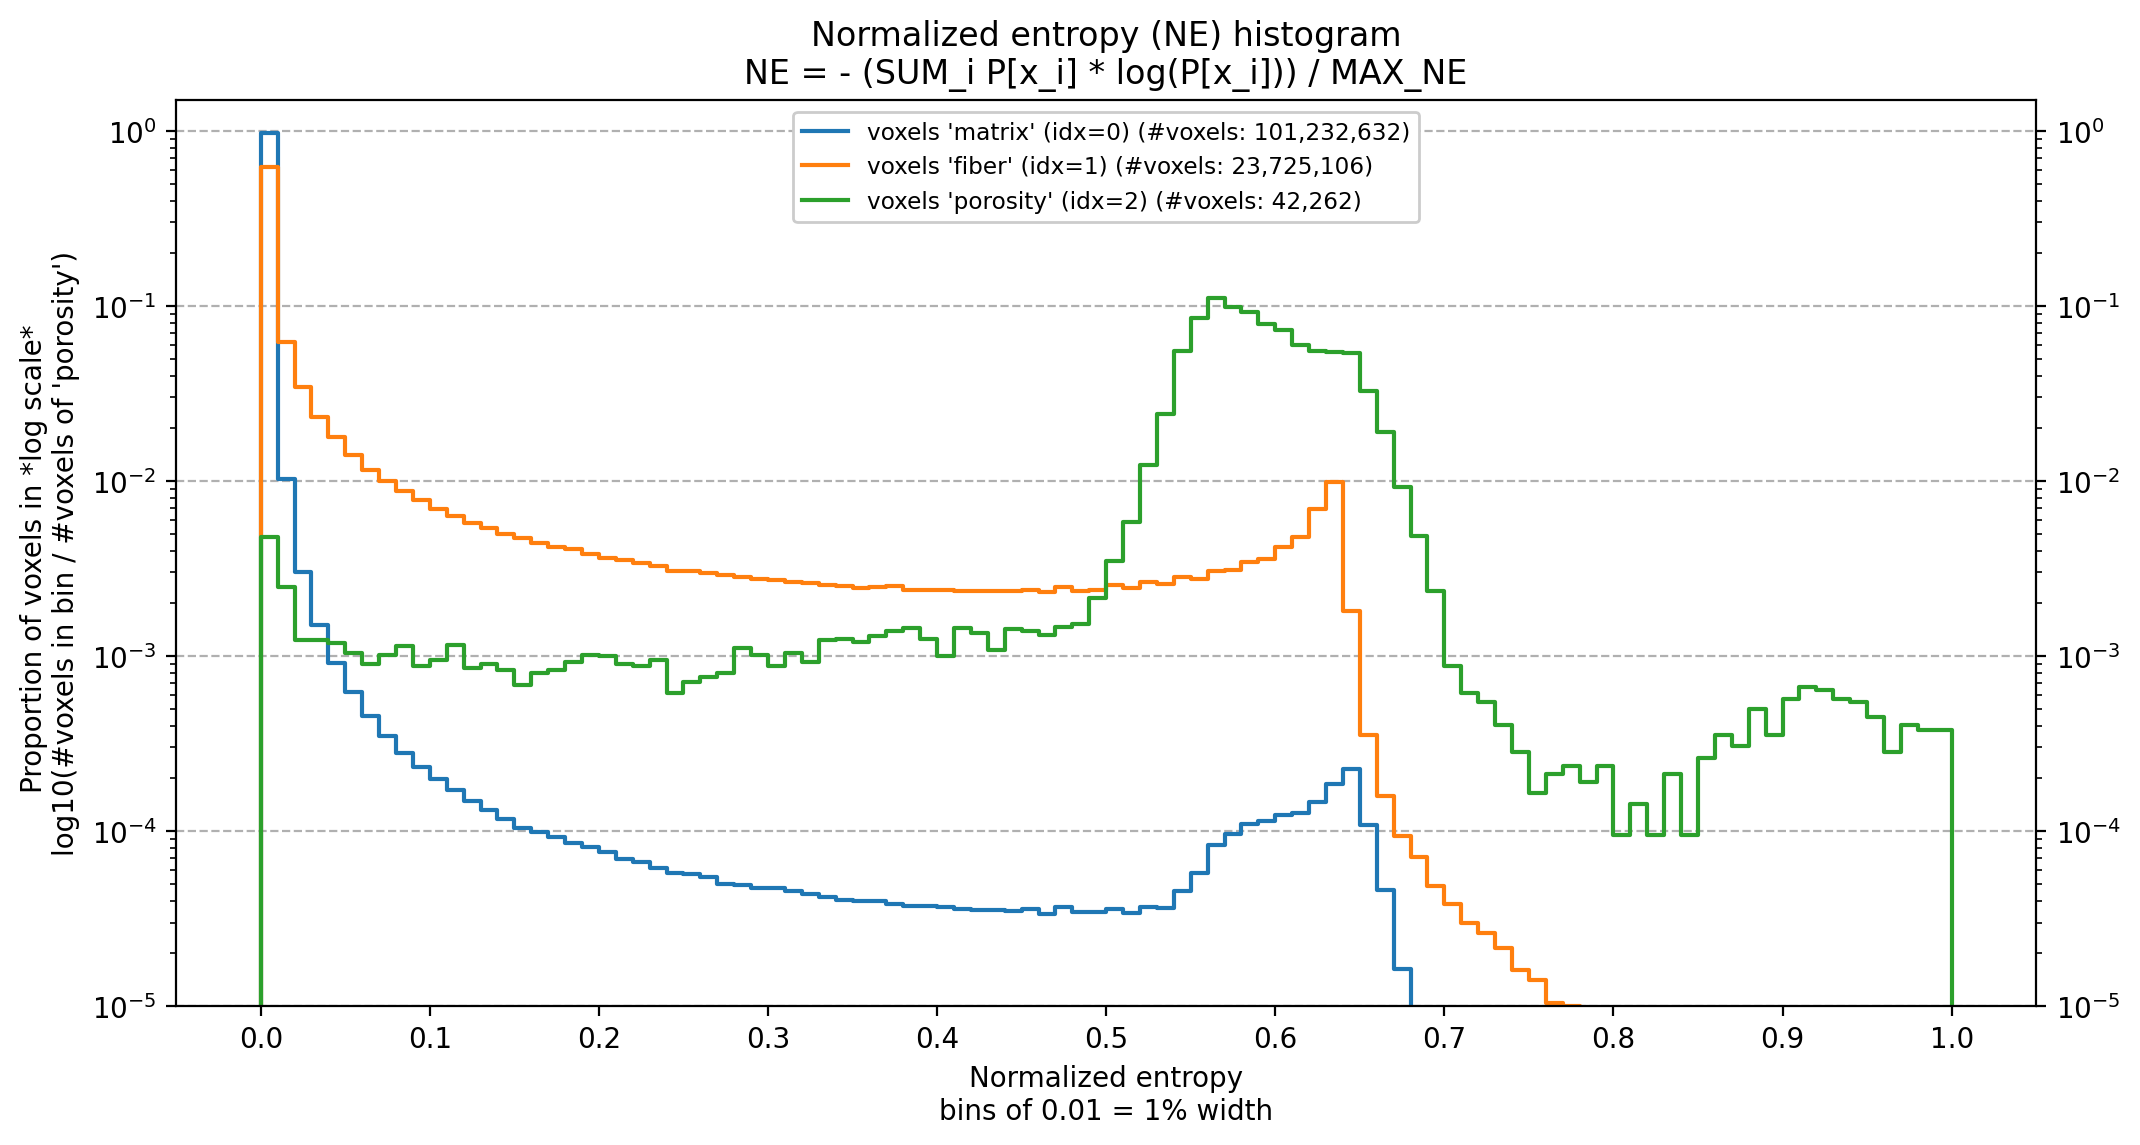

In [243]:
logger.debug(f"Saving figure {(fig_name := 'normalized-entropy-histogram-per-label.png')=}")

fig, ax = plt.subplots(
    1, 1, figsize=(2 * (sz := 6), sz), dpi=(dpi := 200),
)
xlims = (-.05, 1.05)
ylims_10pow = (-5, 0)
ylims = tuple(10 ** p for p in ylims_10pow)

for label_idx in labels_idx:
    logger.debug(f"Plotting histogram for {label_idx=}")
    
    ax.step(
        np.concatenate([bins, [1.001]]),
        np.concatenate([[0], entropy_histograms[label_idx], [0]]),
        label=f"voxels '{labels_names[label_idx]}' (idx={label_idx}) (#voxels: {humanize.intcomma(labels_counts[label_idx])})",
        linewidth=1.5
    )
    
    ax.set_yscale('log')
    ax.set_ylim(ylims[0], 1.5 * ylims[1])
    ax.set_yticks(np.logspace(ylims_10pow[0], ylims_10pow[1], ylims_10pow[1] - ylims_10pow[0] + 1))
    ax.set_ylabel(
        f"Proportion of voxels in *log scale* \n"
        f"log10(#voxels in bin / #voxels of '{(label_name := labels_names[label_idx])}')"
    )
    
    ax.set_xlim(*xlims)
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.set_xlabel("Normalized entropy\nbins of 0.01 = 1% width")

    ax.tick_params(axis='y', left=True, right=True, labelleft=True, labelright=True, which="both")    
    ax.grid(True, axis='y', which='major', ls='--')    
    
    ax.set_title(
        f"Normalized entropy (NE) histogram\n"
        f"NE = - (SUM_i P[x_i] * log(P[x_i])) / MAX_NE" 
    )
    ax.legend(loc="upper center", fontsize="small", framealpha=1)

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Probabilities plane (2D)

It is possible to visualize the probabilities on a plane because 

$$\sum_{i = 1}^{n\_classes} p_i = 1$$

So, when $n\_classes = 3$, we actually have 2 degrees of freedom. 

In [45]:
import matplotlib

[2020-11-05::22:50:42.556] tomo2seg :: INFO :: {<timed exec>:<module>:001}
Saving figure of probabilities scattered on a plane (fig_name := f'probabilities-scatter.png')='probabilities-scatter.png'

[2020-11-05::22:50:42.580] tomo2seg :: DEBUG :: {<timed exec>:<module>:014}
(x_label, y_label, z_label)=(0, 1, 2)

[2020-11-05::22:50:42.582] tomo2seg :: DEBUG :: {<timed exec>:<module>:027}
n_per_label=10000

[2020-11-05::22:50:42.616] tomo2seg :: DEBUG :: {<timed exec>:<module>:051}
label_idx=0

[2020-11-05::22:50:52.680] tomo2seg :: DEBUG :: {<timed exec>:<module>:057}
label_idx=0  len(sample)=10000

[2020-11-05::22:50:52.685] tomo2seg :: DEBUG :: {<timed exec>:<module>:051}
label_idx=1

[2020-11-05::22:50:55.882] tomo2seg :: DEBUG :: {<timed exec>:<module>:057}
label_idx=1  len(sample)=10000

[2020-11-05::22:50:55.888] tomo2seg :: DEBUG :: {<timed exec>:<module>:051}
label_idx=2

[2020-11-05::22:50:57.365] tomo2seg :: DEBUG :: {<timed exec>:<module>:057}
label_idx=2  len(sample)=10000



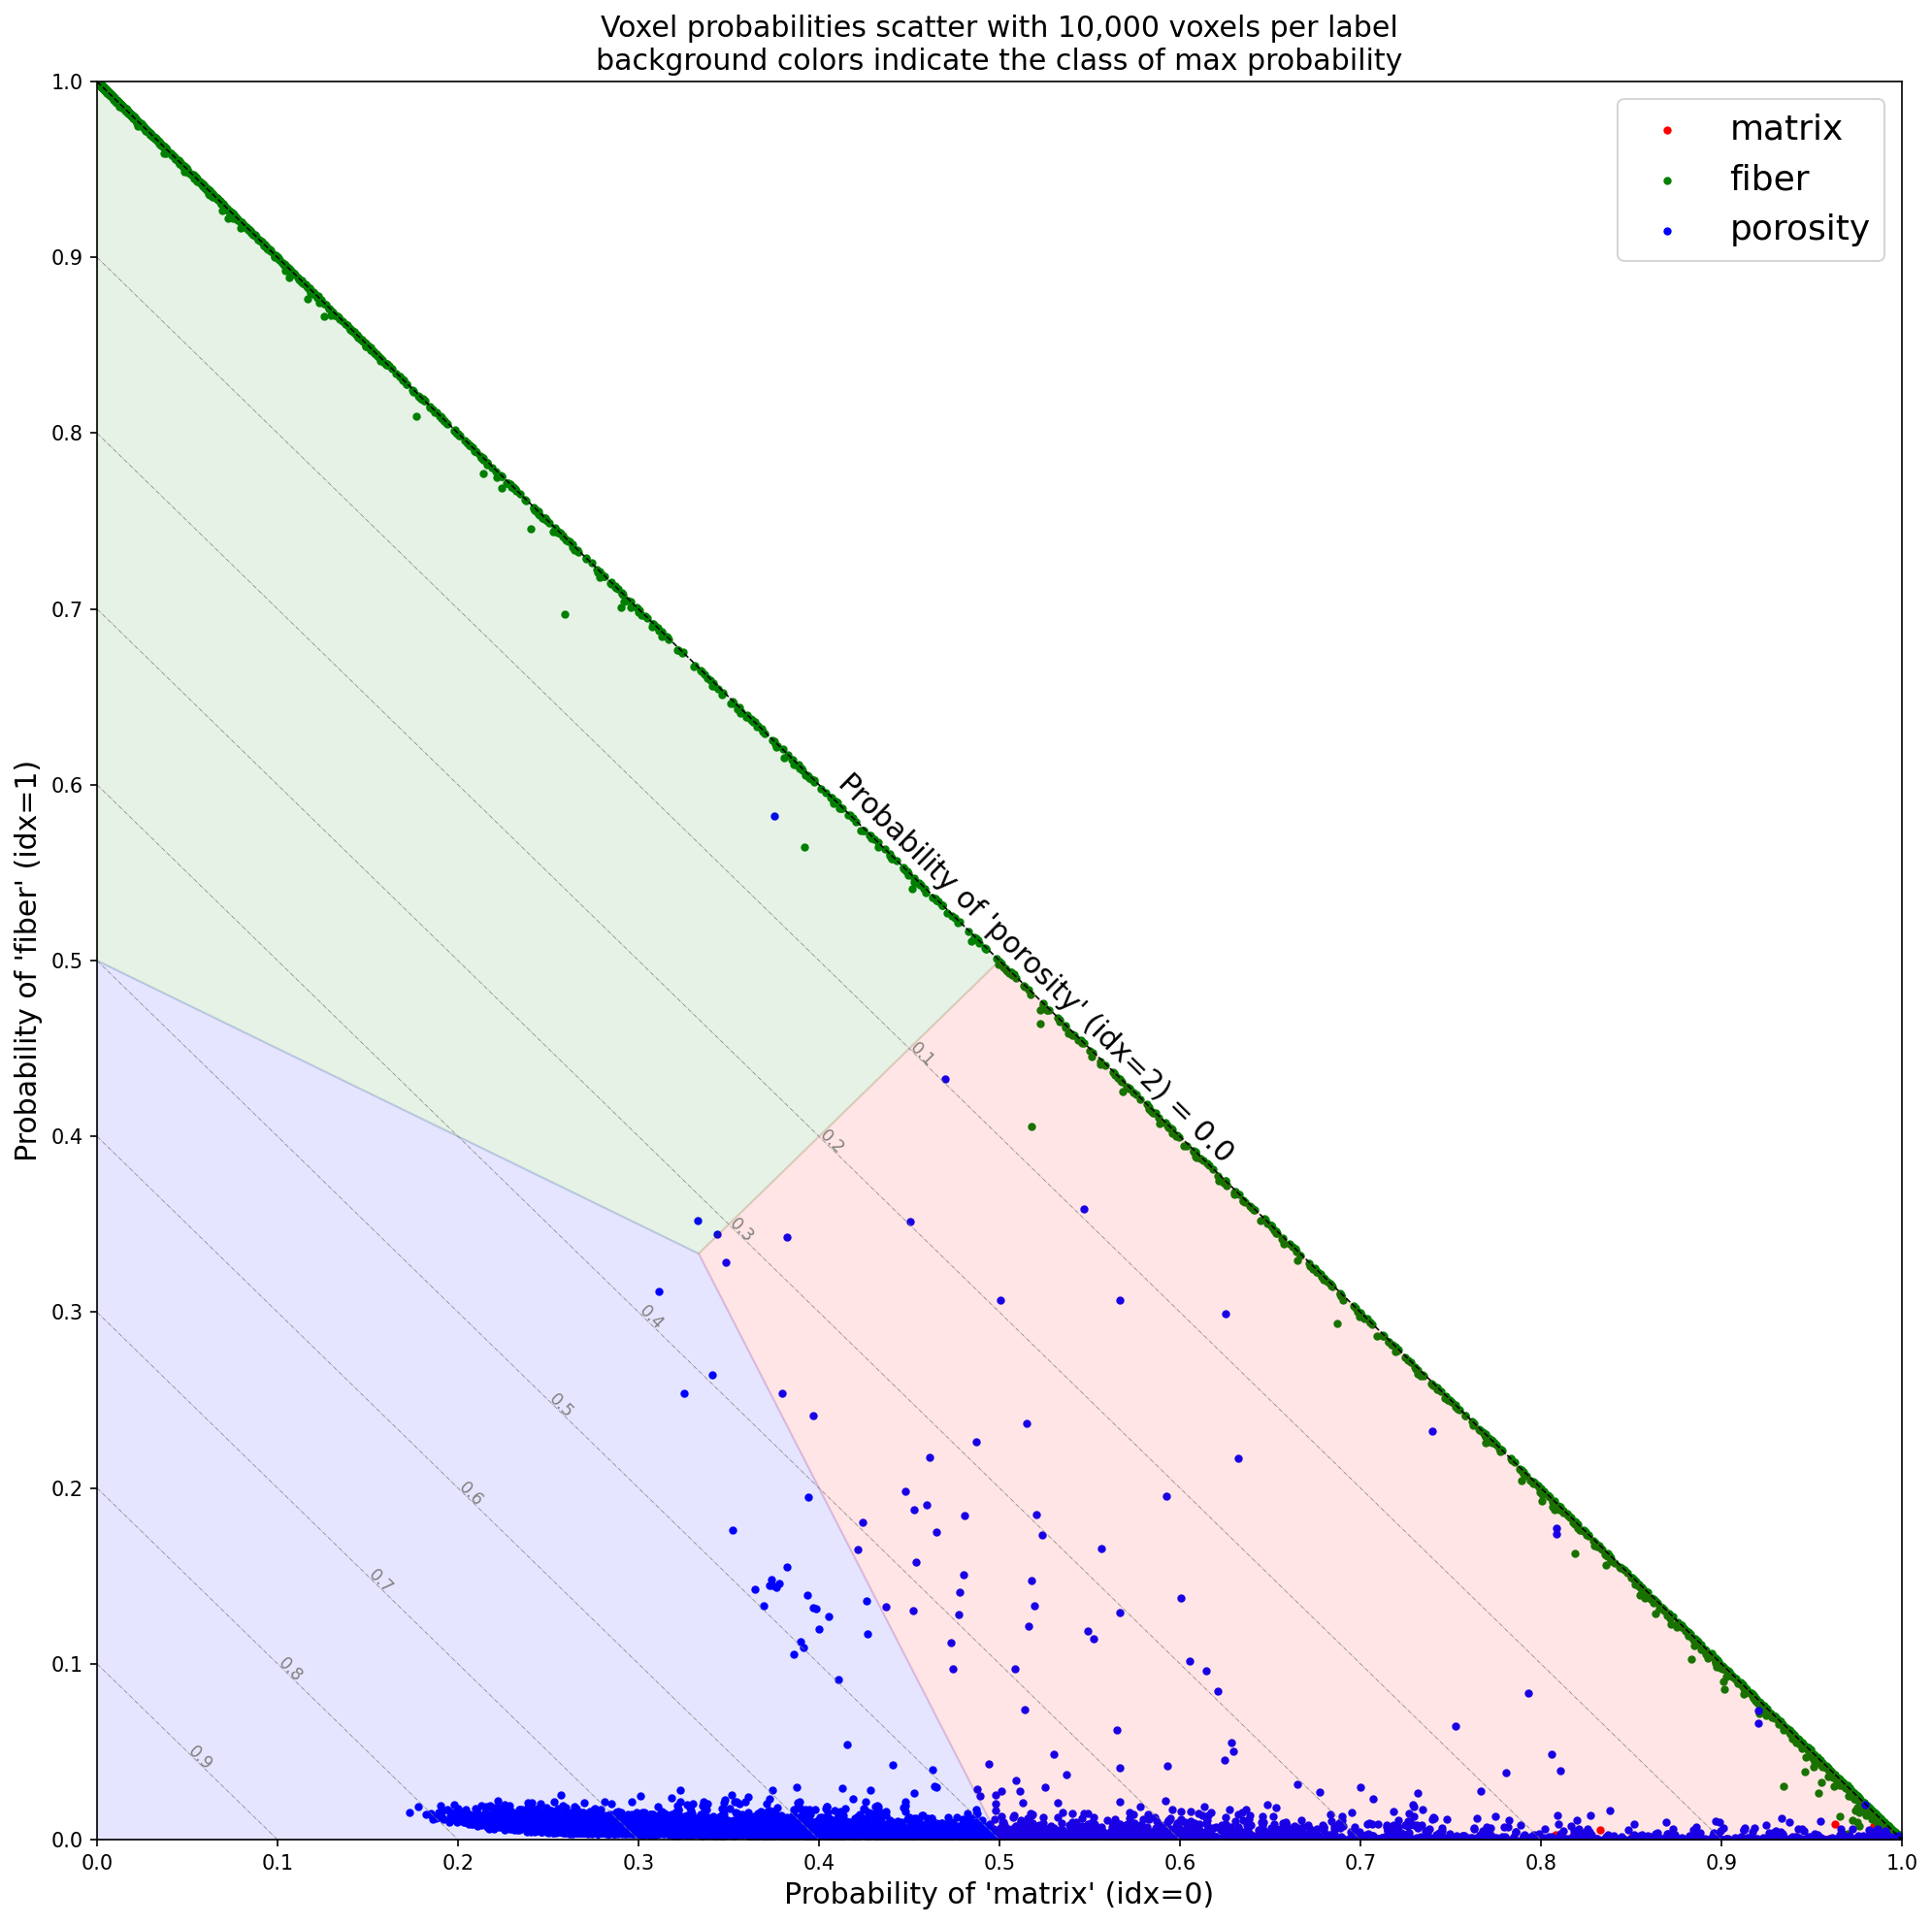

In [55]:
%%time

logger.info(
    f"Saving figure of probabilities scattered on a plane {(fig_name := f'probabilities-scatter.png')=}"
)

fig, ax = plt.subplots(
    n_rows := 1, 
    n_cols := 1, 
    figsize=(n_cols * (sz := 16), n_rows * sz), 
    dpi=(dpi := 150),
)

x_label, y_label, z_label = labels_idx

logger.debug(f"{(x_label, y_label, z_label)=}")

colors = ['r', 'g', 'b']
argmax_points = [
    xmax_points := np.array([[.5, 0], [1, 0], [.5, .5], [1./3, 1./3]]),
    ymax_points := np.vstack([xmax_points[:, 1], xmax_points[:, 0]]).T,
    zmax_points := np.array([[0, 0], [0, .5], [1./3, 1./3], [.5, 0]]),
]

for points, c in zip(argmax_points, colors):
    ax.add_patch(matplotlib.patches.Polygon(points, color=c, alpha=.1))

n_per_label = int(1e4)
logger.debug(f"{n_per_label=}")

ax.set_xlim(0, 1 + (margin := .00))
ax.set_ylim(0, 1 + margin)

ticks = np.linspace(0, 1, 11)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_title(
    f"Voxel probabilities scatter with {humanize.intcomma(n_per_label)} voxels per label\n"
    "background colors indicate the class of max probability",
    fontsize='x-large'
) 
ax.set_xlabel(f"Probability of '{labels_names[x_label]}' (idx={x_label})", fontsize='x-large')
ax.set_ylabel(f"Probability of '{labels_names[y_label]}' (idx={y_label})", fontsize='x-large')

for third_proba in ticks[1:-1]:
    ax.plot([0, third_proba], [third_proba, 0], c='gray', ls='-.', linewidth=.35)
    ax.text(third_proba / 2, third_proba / 2, f"{1. - third_proba:.1f}", c='gray', rotation=-45, rotation_mode='anchor', fontsize='small')
ax.plot([0, 1], [1, 0], c='k', ls='--', linewidth=.75)
ax.text((p := .4) + .01, 1 - p, f"Probability of '{labels_names[z_label]}' (idx={z_label}) = 0.0", c='k', rotation=-44.5, rotation_mode='anchor', fontsize='x-large')

for label_idx, c, label_name in zip(labels_idx, colors, labels_names):
    logger.debug(f"{label_idx=}")
    sample = probas_volume_reshaped[labels_volume.ravel() == label_idx, :]
    idx = random_state.choice(
        np.arange(0, len(sample)), size=n_per_label, replace=False
    )
    sample = sample[idx, :]
    logger.debug(f"{label_idx=}  {len(sample)=}")
    ax.scatter(
        sample[:, x_label], sample[:, y_label],
        c=c, marker='.', label=label_name
    )
    
ax.legend(loc='upper right', fontsize='xx-large')

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

In [ ]:
del probas_volume_reshaped

# Pixel-wise metrics

## Classification report

In [17]:
classification_report_func = functools.partial(
    metrics.classification_report,
    # options
    labels=labels_idx,
    target_names=labels_names,
    sample_weight=None,
    output_dict=True,
    zero_division="warn",
)

[2020-11-03::16:57:12.362] tomo2seg :: DEBUG :: {<ipython-input-17-ef4dda3b61e3>:<module>:001}
Computing classification report



In [18]:
%%time
logger.info("Computing classification report")
classification_report = classification_report_func(
    labels_volume.ravel(), predictions_volume.ravel(),
)

CPU times: user 2min 36s, sys: 10.3 s, total: 2min 47s
Wall time: 2min 48s


### extra: jaccard

In [19]:
jaccard_binary_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average=None
)

jaccard_macro_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="macro",
)

jaccard_weighted_func = functools.partial(
    metrics.jaccard_score, labels=labels_idx, average="weighted",
)

In [20]:
logger.info("Computing jaccard score.")

logger.debug("Computing jaccard score per label.")
bin_jacc = jaccard_binary_func(labels_volume.ravel(), predictions_volume.ravel())

for label_idx, label_name in zip(labels_idx, labels_names):
    classification_report[label_name]["jaccard"] = float(bin_jacc[label_idx])
    
logger.debug("Computing jaccard score averages.")
classification_report["macro avg"]["jaccard"] = float(
    jaccard_macro_func(labels_volume.ravel(), predictions_volume.ravel())
)
classification_report["weighted avg"]["jaccard"] = float(
    jaccard_weighted_func(labels_volume.ravel(), predictions_volume.ravel())
)

[2020-11-03::17:00:05.566] tomo2seg :: DEBUG :: {<ipython-input-20-5ded9c61ed33>:<module>:001}
Computing jaccard score per label.

[2020-11-03::17:00:44.659] tomo2seg :: DEBUG :: {<ipython-input-20-5ded9c61ed33>:<module>:007}
Computing jaccard score averages.



### extra: Normalized Discounted Cumulative Gain (ndcg)

In [35]:
%%time

if probabilities_are_available:
    logger.info("Probabilities are availabe, computing NDCG")

    ohe = preprocessing.OneHotEncoder(
        categories=[labels_idx], dtype=np.int8, handle_unknown="error"
    )

    # even if categories are given, fit() still has to be called
    ohe.fit(np.array(labels_idx).reshape(-1, 1))
    
    # computing with everthing will take too long
    logger.debug(f"{(ndcg_n_samples := 10**6)=}")
    
    logger.debug(f"Sampling voxels {ndcg_n_samples=}")
    ndcg_indices = random_state.choice(
        np.arange(0, n_voxels), replace=False, size=ndcg_n_samples
    )

    ndcg_labels = labels_volume.ravel()[ndcg_indices]
    ndcg_probas = probas_volume.reshape(-1, n_classes)[ndcg_indices, :]
    
    logger.debug(f"Number of pixels of each class: {dict(Counter(ndcg_labels))}")    
    
    logger.info(f"Computing ndcg score")
    classification_report["ndcg"] = float(metrics.ndcg_score(
        ohe.transform(ndcg_labels.reshape(-1, 1)).toarray(), ndcg_probas
    ))

[2020-11-03::17:04:44.076] tomo2seg :: INFO :: {<timed exec>:<module>:002}
Probabilities are availabe, computing NDCG

[2020-11-03::17:04:44.077] tomo2seg :: DEBUG :: {<timed exec>:<module>:012}
(ndcg_n_samples := 10**6)=1000000

[2020-11-03::17:04:44.078] tomo2seg :: DEBUG :: {<timed exec>:<module>:014}
Sampling voxels

[2020-11-03::17:04:53.112] tomo2seg :: DEBUG :: {<timed exec>:<module>:022}
Number of pixels of each class: {0: 809896, 1: 189778, 2: 326}

[2020-11-03::17:04:53.113] tomo2seg :: INFO :: {<timed exec>:<module>:024}
Computing ndcg score

CPU times: user 1min 54s, sys: 593 ms, total: 1min 54s
Wall time: 1min 54s


### Save

In [36]:
class HumanizedDumper(yaml.Dumper):
    pass
   

def percentage_float_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{value:.2%}")


def humanize_int_representer(dumper, value):
    return dumper.represent_scalar(u'tag:yaml.org,2002:str', f"{humanize.intword(value)} ({humanize.intcomma(value)})")


HumanizedDumper.add_representer(float, percentage_float_representer)
HumanizedDumper.add_representer(int, humanize_int_representer)

In [37]:
yaml_dump_classification_report = functools.partial(
    yaml.dump,
    default_flow_style=False, 
    indent=4, 
    sort_keys=False
)

In [40]:
logger.info(
    f"Saving exact and humanized classification report to (respectively):"
    f"\n{estimation_volume.pixelwise_classification_report_exact}"
    f"\n{estimation_volume.pixelwise_classification_report_human}"
)

with estimation_volume.pixelwise_classification_report_exact.open('w') as f:
    yaml_dump_classification_report(classification_report, f)

with estimation_volume.pixelwise_classification_report_human.open('w') as f:
    report_str = yaml_dump_classification_report(classification_report, Dumper=HumanizedDumper)
    f.write(report_str)

[2020-11-03::18:01:03.340] tomo2seg :: DEBUG :: {<ipython-input-40-08082fd5d81e>:<module>:001}
Saving exact and humanized classification report to (respectively):
/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.classification_report.exact.yaml
/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.classification_report.human.yaml



In [41]:
print(report_str)

matrix:
    precision: 95.81%
    recall: 99.94%
    f1-score: 97.83%
    support: 101.2 million (101,232,632)
    jaccard: 95.76%
fiber:
    precision: 100.00%
    recall: 81.40%
    f1-score: 89.74%
    support: 23.7 million (23,725,106)
    jaccard: 81.40%
porosity:
    precision: 37.83%
    recall: 84.54%
    f1-score: 52.27%
    support: 42262 (42,262)
    jaccard: 35.38%
accuracy: 96.42%
macro avg:
    precision: 77.88%
    recall: 88.63%
    f1-score: 79.95%
    support: 125.0 million (125,000,000)
    jaccard: 70.84%
weighted avg:
    precision: 96.59%
    recall: 96.42%
    f1-score: 96.28%
    support: 125.0 million (125,000,000)
    jaccard: 93.01%
ndcg: 98.62%



In [82]:
with estimation_volume.pixelwise_classification_report_exact.open() as f:
# with estimation_volume.pixelwise_classification_report_human.open() as f:
    classification_report = yaml.load(f, Loader=yaml.Loader)

In [71]:
table = []
cols = sorted(classification_report['macro avg'].keys())
idx = []
# table.append([''] + headers)

for key, val in classification_report.items():
    if type(val) != dict:
        continue
    idx.append(key)
    table.append([
        val[dic_key]
        for dic_key in headers
    ])
                

In [69]:
import pandas as pd

In [72]:
df = pd.DataFrame(table, columns=headers, index=idx)

In [77]:
df[['support', 'precision', 'recall']]

,support,precision,recall
matrix,"101.2 million (101,232,632)",95.81%,99.94%
fiber,"23.7 million (23,725,106)",100.00%,81.40%
porosity,"42262 (42,262)",37.83%,84.54%
macro avg,"125.0 million (125,000,000)",77.88%,88.63%
weighted avg,"125.0 million (125,000,000)",96.59%,96.42%


In [80]:
df[['support', 'f1-score']]

,support,f1-score
matrix,"101.2 million (101,232,632)",97.83%
fiber,"23.7 million (23,725,106)",89.74%
porosity,"42262 (42,262)",52.27%
macro avg,"125.0 million (125,000,000)",79.95%
weighted avg,"125.0 million (125,000,000)",96.28%


In [81]:
df[['support', 'jaccard']]

,support,jaccard
matrix,"101.2 million (101,232,632)",95.76%
fiber,"23.7 million (23,725,106)",81.40%
porosity,"42262 (42,262)",35.38%
macro avg,"125.0 million (125,000,000)",70.84%
weighted avg,"125.0 million (125,000,000)",93.01%


## Confusion matrix

In [42]:
%%time

logger.info("Computing confusion matrix.")

# doing it in batches to fit my pc memory...
n_batches = 30
batch_indices = np.linspace(0, n_voxels, n_batches + 1).astype(int)

confusion_matrix = np.zeros((n_classes, n_classes))

for s, e in pbar(zip(batch_indices[:-1], batch_indices[1:]), max_value=n_batches):
    confusion_matrix += metrics.confusion_matrix(
        # data
        labels_volume.ravel()[s:e], predictions_volume.ravel()[s:e],
        # options
        labels=volume.metadata.labels,
        sample_weight=None,
    )

100% (30 of 30) |########################| Elapsed Time: 0:02:56 Time:  0:02:56


CPU times: user 2min 54s, sys: 2.13 s, total: 2min 56s
Wall time: 2min 56s


In [58]:
logger.info(f"Saving confusion matrix to {estimation_volume.confusion_matrix_path=}.")

np.save(
    estimation_volume.confusion_matrix_path,
    confusion_matrix
)

[2020-11-03::19:15:47.813] tomo2seg :: INFO :: {<ipython-input-58-b8ed2af3b858>:<module>:001}
Saving confusion matrix to estimation_volume.confusion_matrix_path=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.confusion_matrix.npy').



[2020-11-03::22:41:50.522] tomo2seg :: DEBUG :: {<ipython-input-58-f9c4d679b2bf>:<module>:001}
Saving figure (fig_name := 'confusion-matrix.png')='confusion-matrix.png'



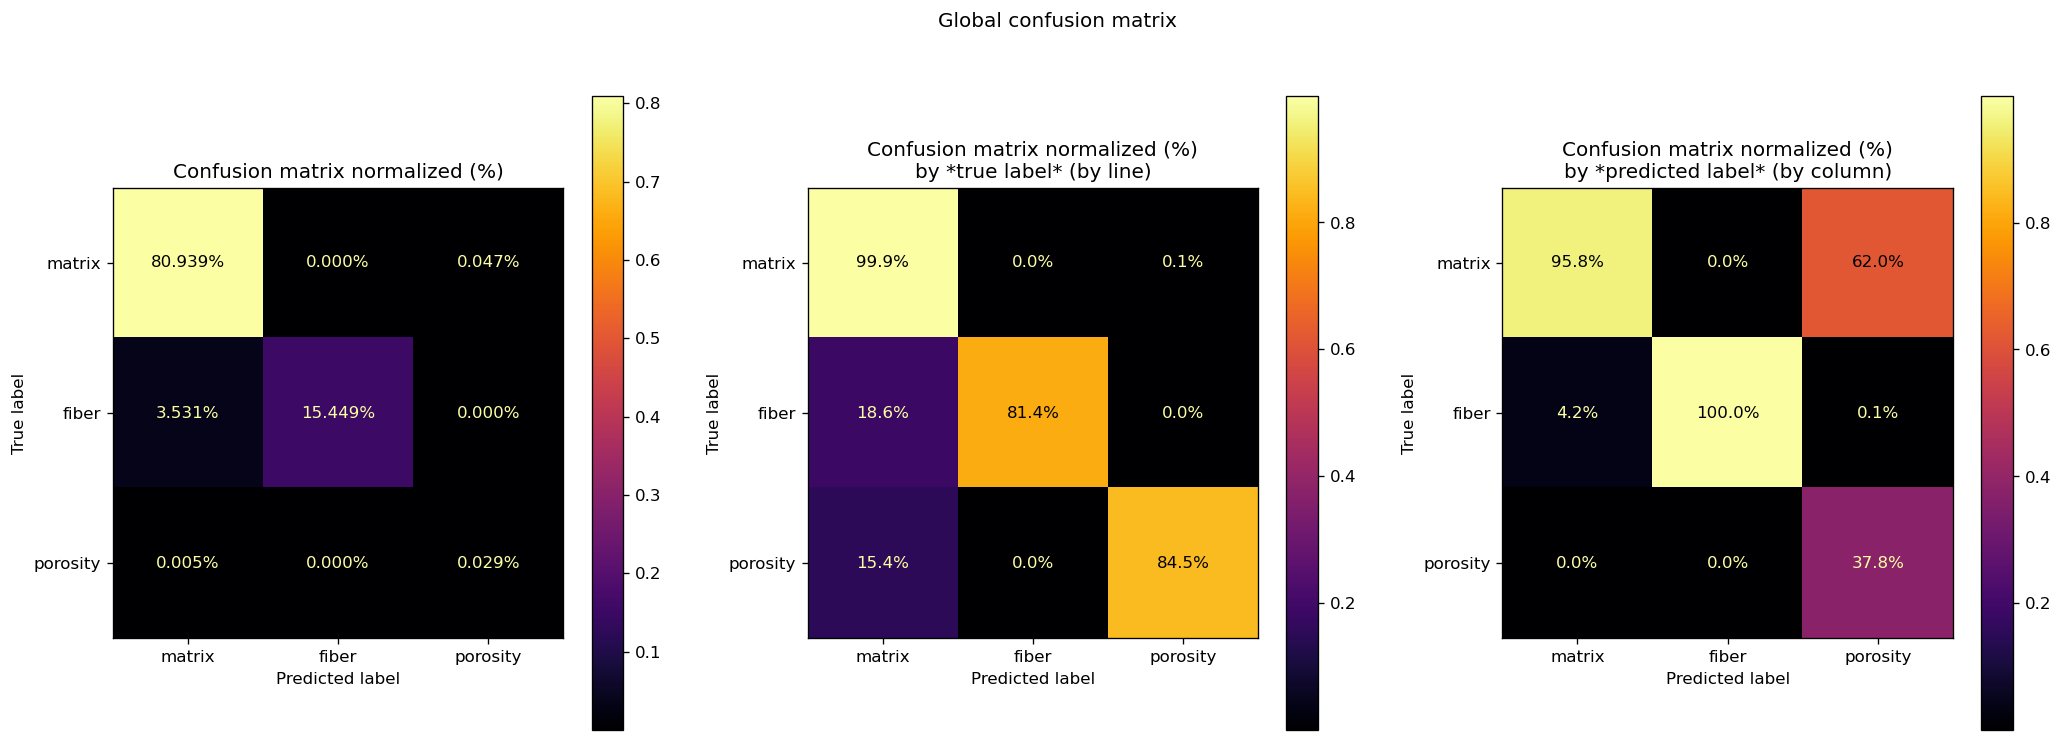

In [58]:
logger.debug(f"Saving figure {(fig_name := 'confusion-matrix.png')=}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 3, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/30),
)

cm_display = metrics.ConfusionMatrixDisplay(
    cm_normalized := confusion_matrix / confusion_matrix.sum(), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.3%', cmap=cm.inferno, ax=axs[0])
cm_display.ax_.set_title("Confusion matrix normalized (%)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_true_label_normalized := confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1, 1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[1])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *true label* (by line)")

cm_display = metrics.ConfusionMatrixDisplay(
    cm_predicted_label_normalized := confusion_matrix / confusion_matrix.sum(axis=0).reshape(1, -1), 
    display_labels=labels_names,
)
cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=axs[2])
cm_display.ax_.set_title("Confusion matrix normalized (%)\nby *predicted label* (by column)")

fig.suptitle("Global confusion matrix")

fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

## Binary confusion matrices

In [59]:
logger.info("Computing binary confusion matrices (per label).")

binary_confusion_matrices = []

for label_idx in range(n_classes):
    tp = confusion_matrix[label_idx, label_idx]
    fn = confusion_matrix[label_idx, :].sum() - tp
    fp = confusion_matrix[:, label_idx].sum() - tp
    tn = confusion_matrix.sum() - fp - fn - tp
    binary_confusion_matrices.append([
        [tn, fp],
        [fn, tp],
    ])
    
binary_confusion_matrices = np.array(binary_confusion_matrices)

logger.debug(f"{binary_confusion_matrices.shape=}")

[2020-11-03::22:46:31.140] tomo2seg :: INFO :: {<ipython-input-59-c2878c54b2e0>:<module>:001}
Computing binary confusion matrices (per label).

[2020-11-03::22:46:31.142] tomo2seg :: DEBUG :: {<ipython-input-59-c2878c54b2e0>:<module>:017}
binary_confusion_matrices.shape=(3, 2, 2)



In [59]:
logger.info(f"Saving binary confusion matrices to {estimation_volume.binary_confusion_matrices_path}.")
np.save(
    estimation_volume.binary_confusion_matrices_path,
    binary_confusion_matrices
)

[2020-11-03::19:16:42.020] tomo2seg :: INFO :: {<ipython-input-59-4e7148cd3762>:<module>:001}
Saving binary confusion matrices to /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.binary_confusion_matrices.npy.



[2020-11-03::22:47:47.679] tomo2seg :: INFO :: {<ipython-input-60-da629e156ee1>:<module>:001}
Saving figure of binary confusion matrices at (fig_name := f'binary-confusion-matrices.png')='binary-confusion-matrices.png'

[2020-11-03::22:47:47.809] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<module>:015}
Drawing CM of class label_idx=0 (1st line)

[2020-11-03::22:47:47.859] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<module>:015}
Drawing CM of class label_idx=1 (1st line)

[2020-11-03::22:47:47.906] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<module>:015}
Drawing CM of class label_idx=2 (1st line)

[2020-11-03::22:47:47.948] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<module>:029}
Drawing CM of class label_idx=0 (2nd line)

[2020-11-03::22:47:47.983] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<module>:029}
Drawing CM of class label_idx=1 (2nd line)

[2020-11-03::22:47:48.017] tomo2seg :: DEBUG :: {<ipython-input-60-da629e156ee1>:<mod

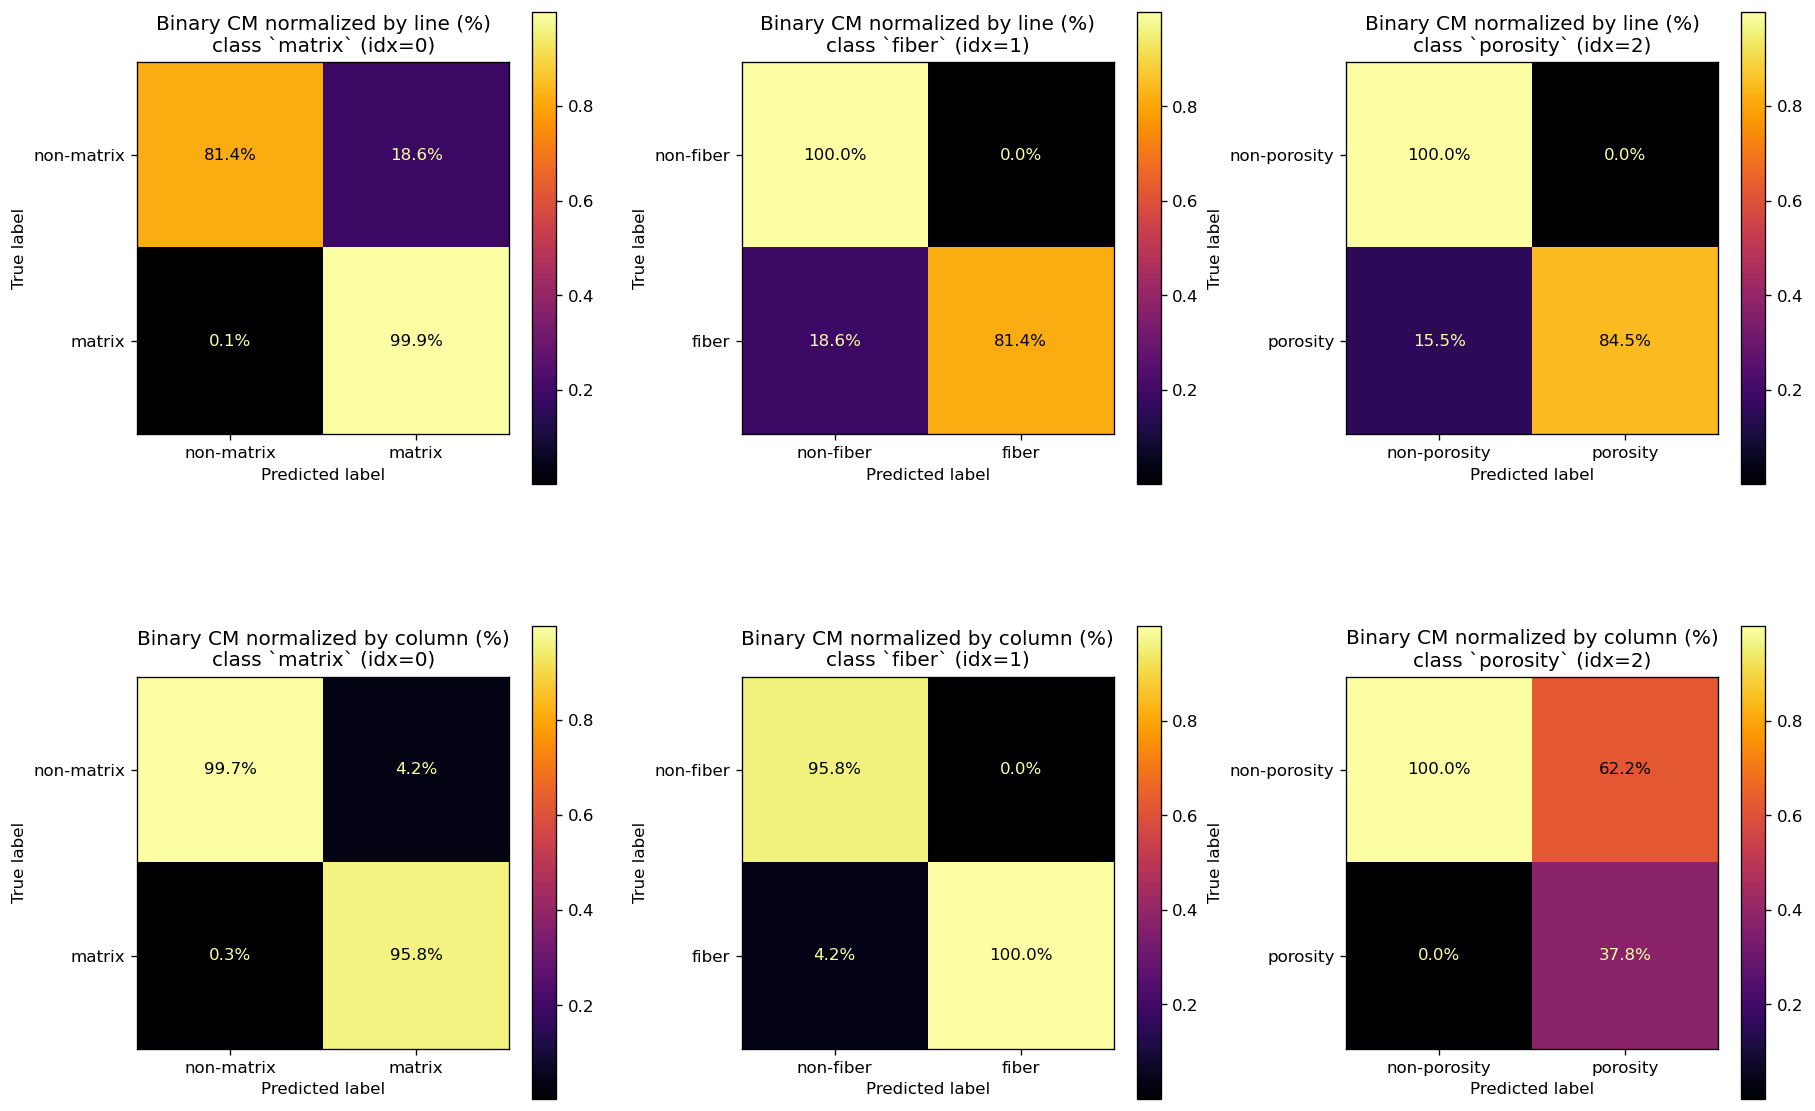

In [60]:
logger.info(
    f"Saving figure of binary confusion matrices at "
    f"{(fig_name := f'binary-confusion-matrices.png')=}"
)

fig, axs = plt.subplots(
    n_rows := 2, 
    n_cols := n_classes, 
    figsize=(n_cols * (sz := 6), n_rows * sz), 
    dpi=(dpi := 120),
    gridspec_kw=dict(wspace=sz/20, hspace=sz/20),
)

for label_idx, ax in zip(labels_idx, axs[0].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (1st line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=1).reshape(-1, 1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by line (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )

for label_idx, ax in zip(labels_idx, axs[1].ravel()):
    logger.debug(f"Drawing CM of class {label_idx=} (2nd line)")
    confmat = binary_confusion_matrices[label_idx]
    
    cm_display = metrics.ConfusionMatrixDisplay(
        confmat / confmat.sum(axis=0).reshape(1, -1), 
        display_labels=[f"non-{(label_name := labels_names[label_idx])}", label_name],
    )
    cm_display.plot(values_format='.1%', cmap=cm.inferno, ax=ax)
    cm_display.ax_.set_title(
        f"Binary CM normalized by column (%)\n"
        f"class `{label_name}` (idx={label_idx})"
    )


fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

## ROC curves

In [80]:
logger.info("Computing ROC curves")

roc_curves = []

for label_idx in labels_idx:
    logger.debug(f"Computing roc curve of class idx={label_idx}")
    
    fpr, tpr, th = metrics.roc_curve(
        labels_volume.ravel(), probas_volume.reshape(-1, n_classes)[:, label_idx], 
        pos_label=label_idx,
        drop_intermediate=True
    )
    roc_curves.append((
        label_roc_curve := np.array([fpr, tpr, th])
    ))
    
    logger.debug(
        f"Saving roc curve of class idx={label_idx} "
        f"at {(roc_path := estimation_volume.get_class_roc_curve_path(label_idx))=}"
    )
    np.save(roc_path,label_roc_curve)

[2020-11-03::19:38:34.993] tomo2seg :: INFO :: {<ipython-input-80-0040b9433c04>:<module>:001}
Computing ROC curves

[2020-11-03::19:38:34.994] tomo2seg :: DEBUG :: {<ipython-input-80-0040b9433c04>:<module>:006}
Computing roc curve of class idx=0

[2020-11-03::19:39:08.242] tomo2seg :: DEBUG :: {data.py:metadata:132}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/PA66GF30_trans3_x__0_pag.val.metadata.yml`.

[2020-11-03::19:39:08.293] tomo2seg :: DEBUG :: {<ipython-input-80-0040b9433c04>:<module>:017}
Saving roc curve of class idx=0 at (roc_path := estimation_volume.get_class_roc_curve_path(label_idx))=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.roc_curve.class_idx=0.raw')

[2020-11-03::19:39:08.302] tomo2seg :: DEBUG :: {<ipython-input-80-0040b9433c04>:<module>:006}
Com

[2020-11-03::19:54:48.564] tomo2seg :: INFO :: {<ipython-input-106-df777794554c>:<module>:001}
Saving figure of ROC curves at roc-curves.png



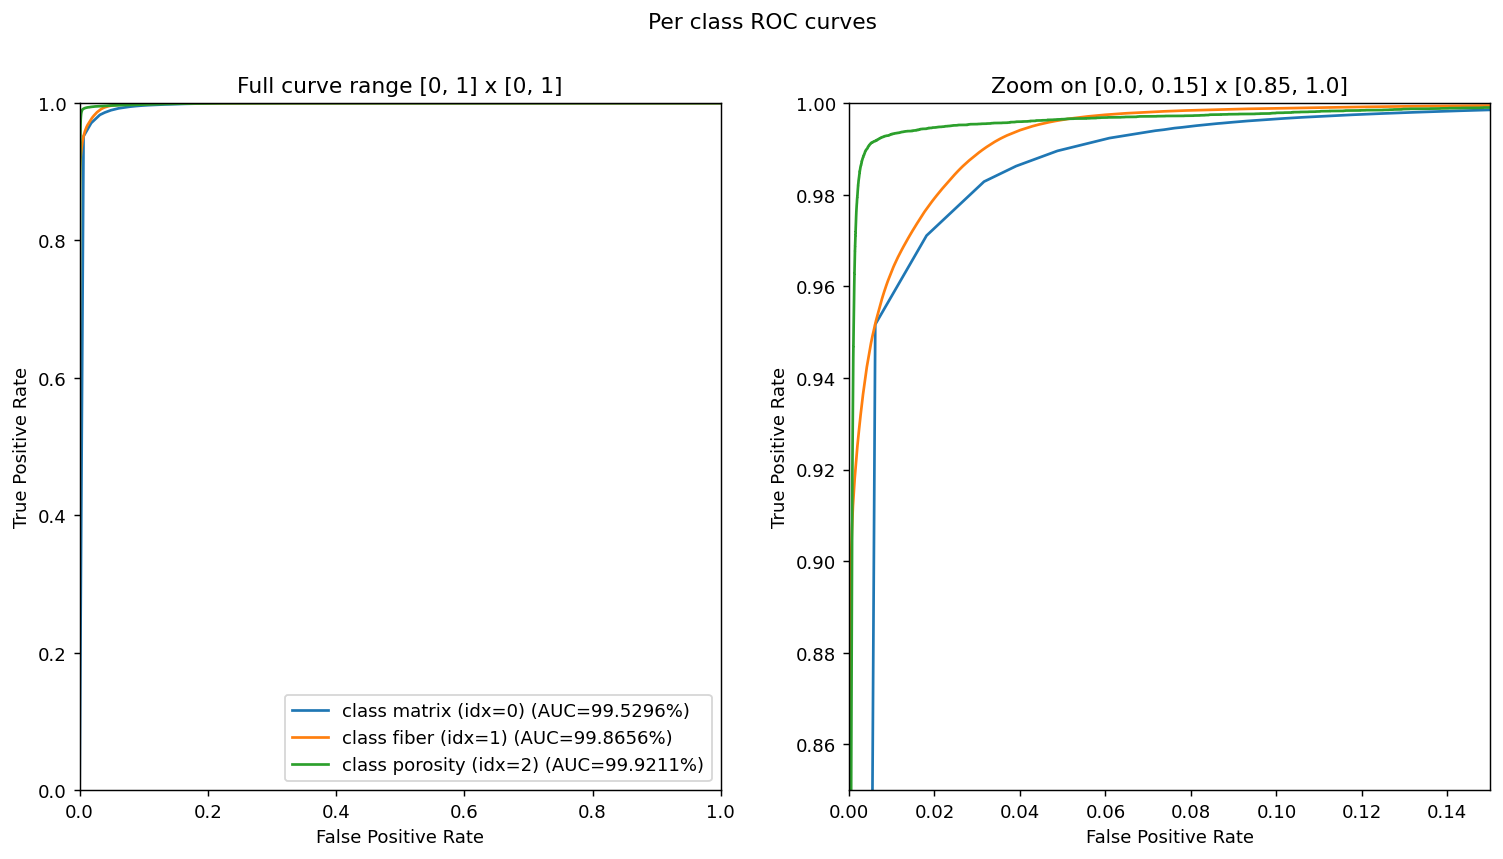

In [106]:
logger.info(f"Saving figure of ROC curves at {(fig_name := f'roc-curves.png')}")

fig, axs = plt.subplots(
    n_rows := 1, 
    n_cols := 2, 
    figsize=(n_cols * (sz := 7), n_rows * sz), 
    dpi=(dpi := 130),
)

zoom = np.array(((0, .15), (.85, 1)))

fig.suptitle("Per class ROC curves")

ax_full, ax_zoom = axs[0], axs[1]
ax_full.set_title("Full curve range [0, 1] x [0, 1]")
ax_full.set_xlim(0, 1)
ax_full.set_ylim(0, 1)

ax_zoom.set_title(f"Zoom on [{zoom[0, 0]}, {zoom[0, 1]}] x [{zoom[1, 0]}, {zoom[1, 1]}]")
ax_zoom.set_xlim(*zoom[0])
ax_zoom.set_ylim(*zoom[1])

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f"{label_idx}")
    for ax in axs:
        roc_display.plot(ax=ax)  

max_label_name_length = max(*map(len, labels_names))

for label_idx, (fpr, tpr, _) in zip(labels_idx, roc_curves):
    ax_full.get_legend().texts[label_idx].set_text(
        f"class {(label_name := labels_names[label_idx])} (idx={label_idx})"
        f" (AUC={(roc_auc := metrics.auc(fpr, tpr)):.4%})"
    )
ax_zoom.legend_ = None
         
fig.savefig(
    fname=estimation_volume.dir / fig_name,
    dpi=dpi,
    **figs_common_kwargs,
    metadata={
        "Title": f"vol={volume.fullname}::analysis::{fig_name}",
        **figs_common_kwargs
    }
)

# Confusion volume

In [19]:
logger.info("Computing confusion volumes")

for label_idx in labels_idx:

    tp_volume = (labels_volume == label_idx) & (predictions_volume == label_idx)
    fn_volume = (labels_volume == label_idx) & (predictions_volume != label_idx)
    fp_volume = (labels_volume != label_idx) & (predictions_volume == label_idx)

    conf_vol = (
        np.zeros_like(labels_volume, dtype=(vol_dtype := np.uint8))
        + 50 * fn_volume.astype(vol_dtype)
        + 100 * fp_volume.astype(vol_dtype)
        + 255 * tp_volume.astype(vol_dtype)
    )
    
    logger.debug(
        f"Saving confusion volume for class {label_idx=} "
        f"at {(str_path := str(estimation_volume.get_confusion_volume_path(label_idx)))=}"
    )
    file_utils.HST_write(conf_vol, str_path)    

[2020-11-03::23:46:20.464] tomo2seg :: INFO :: {<ipython-input-19-d1b9d481c42a>:<module>:001}
Computing confusion volumes

[2020-11-03::23:46:21.461] tomo2seg :: DEBUG :: {<ipython-input-19-d1b9d481c42a>:<module>:016}
Saving confusion volume for class label_idx=0 at (str_path := str(estimation_volume.get_confusion_volume_path(label_idx)))='/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.confusion-volume.class_idx=0.raw'

opening /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30_trans3_x__0_pag.val/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03/vol=PA66GF30_trans3_x__0_pag.val.set=whole-volume.model=dryrun-03.confusion-volume.class_idx=0.raw for writing in mode w
volume size is 500x500x500
data type is uint8
writing .info file
done with writing
[2020-11-03::23:46:22.879] tomo2seg :: DEBUG :: {<ipython-input-19-

## 2D error blobs

## 3D error blobs

# Physical metrics